# PCA for Satellite Data

A short exploration into PCA for multi-spectral satellite data using python.


Principle Component Analysys<sup id='a1'>[1](#f1)</sup> is a technique for reducing
the volume or dimensionality of a complex dataset while preserving as much of the information as possible.

In this workflow we will see how a PCA can reduce an 8-band satellite image into a 3-band image while preserving over 99% of the information.

## Data

For this excercise we will be evaluating a single scene from Planet Labs SuperDove<sup id='a2'>[2](#f2)</sup>
constellation. The earliest imagery
is available from around mid-March, 2020. The constellation is aquiring new imagery
of the entire planet almost daily.

Each SuperDove scene covers approximately 32.5 x 19.6 km<sup>2</sup>. and has a spatial resolution of about 3 meters. Each scene file is about 980Gb on disk.

### Libraries and Data

In [1]:
from datetime import datetime
start = datetime.now()

import rasterio
import dask.array as da
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show


## Load Data

Then, we will load the data. A small clip of a scene is available for testing here.<sup id='a3'>[3](#f3)</sup>


In [2]:
# filename = './data/analytic/analytic_8b_sr_udm2/20221022_152926_36_241b_3B_AnalyticMS_SR_8b.tif'
filename = './data/small.tif'
src = rasterio.open(filename)

band_names = ['coastal_blue',
              'blue',
              'green_i',
              'green',
              'yellow',
              'red',
              'red_edge',
              'nir']

band_numbers = ['1', '2', '3', '4', '5', '6', '7', '8']
pc_names = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']

n_bands = src.meta['count']
img_shape = src.shape

### Summary Statistics

Now, we will look at the raw data and it's distributions.

Because the values in the NIR band (band 8) are so much larger than the other bands it can skew the covariance and eigen values, so we will perform a min-max normalization on the data first


I enjoy Dask so we will use a little dask array here for no other reason than the nice visualization it provides. At scale, dask comes in really handy for processing imagery. Notice the volume of the data in memory is larger than on disk. Here a single scene has expanded from 980mb to 1.72Gb.

A good way to visualize the distribution of pixel values across the 8 bands is to use a kernel-density-estimate plot from seaborn. Careful not to run this on the whole scene - it will take a while. (Possible to spead up by using a dataframe?)

In [3]:
stats_raw = []

for idx, band in enumerate(src.read()):

    stats_raw.append({
        'band': idx + 1,
        'min': band.min(),
        'mean': band.mean(),
        'max': band.max(),
        'std': int(np.std(band)),
        'var': int(np.var(band)),

    })

summary_stats = pd.DataFrame.from_records(
    stats_raw, index='band').astype(int)

summary_stats

,min,mean,max,std,var
band,,,,,
1,1,104,2024,49,2456
2,1,78,2183,51,2686
3,8,230,2346,72,5192
4,37,311,2686,83,6925
5,17,210,2582,82,6804
6,1,118,2670,84,7156
7,120,767,3664,142,20305
8,460,3763,5970,385,148705


In [4]:
foo = []

for idx, band in enumerate(src.read()):

    foo.append({
        'band': idx + 1,
        'vmin': int(band.mean() - np.std(band)),
        'vmax': int(band.mean() + np.std(band)),
    })
    

Text(0.5, 1.0, 'nir')

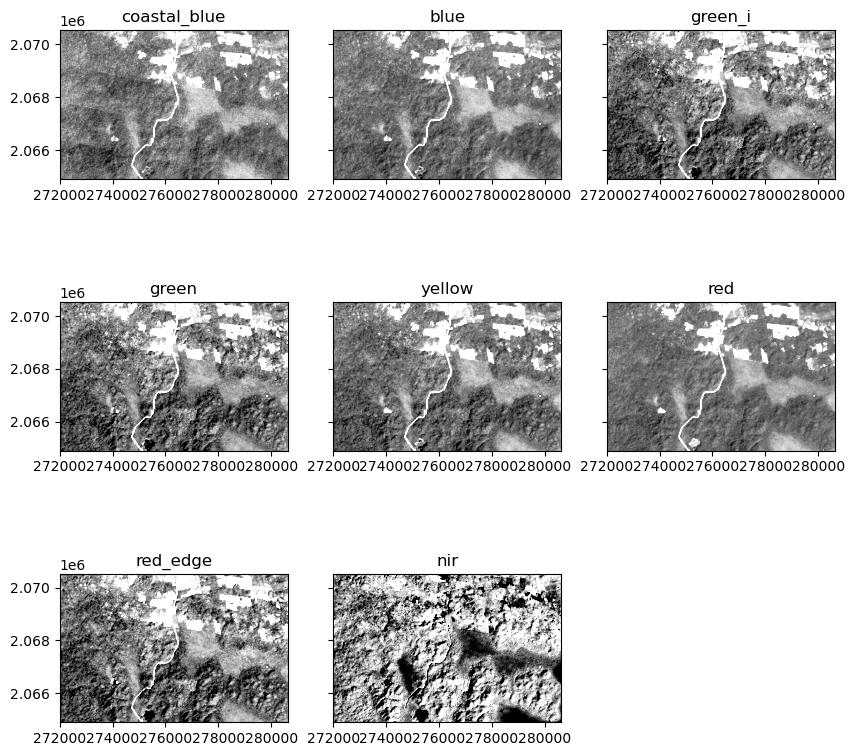

In [5]:

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharey=True)

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

fig.delaxes(ax9)

# plots
show((src, 1), cmap='Greys_r', ax=ax1, vmin=foo[0]['vmin'], vmax=foo[0]['vmax'])
show((src, 2), cmap='Greys_r', ax=ax2, vmin=foo[1]['vmin'], vmax=foo[1]['vmax'])
show((src, 3), cmap='Greys_r', ax=ax3, vmin=foo[2]['vmin'], vmax=foo[2]['vmax'])
show((src, 4), cmap='Greys_r', ax=ax4, vmin=foo[3]['vmin'], vmax=foo[3]['vmax'])
show((src, 5), cmap='Greys_r', ax=ax5, vmin=foo[4]['vmin'], vmax=foo[4]['vmax'])
show((src, 6), cmap='Greys_r', ax=ax6, vmin=foo[5]['vmin'], vmax=foo[5]['vmax'])
show((src, 7), cmap='Greys_r', ax=ax7, vmin=foo[6]['vmin'], vmax=foo[6]['vmax'])
show((src, 8), cmap='Greys_r', ax=ax8, vmin=foo[7]['vmin'], vmax=foo[7]['vmax'])

# add titles
ax1.set_title('coastal_blue')
ax2.set_title('blue')
ax3.set_title('green_i')
ax4.set_title('green')
ax5.set_title('yellow')
ax6.set_title('red')
ax7.set_title('red_edge')
ax8.set_title('nir')

In [6]:
# Read the grid values into dask/numpy arrays
bnd_list = []

for i in range(n_bands):
    bnd = da.from_array(src.read(i+1))
    bnd_list.append(bnd)

dask_band_stack = da.dstack(bnd_list)
dask_band_stack = dask_band_stack.rechunk('auto')
src_sr = dask_band_stack.compute()

dask_band_stack

dask.array<rechunk-merge, shape=(1874, 2874, 8), dtype=uint16, chunksize=(1874, 2874, 8), chunktype=numpy.ndarray>

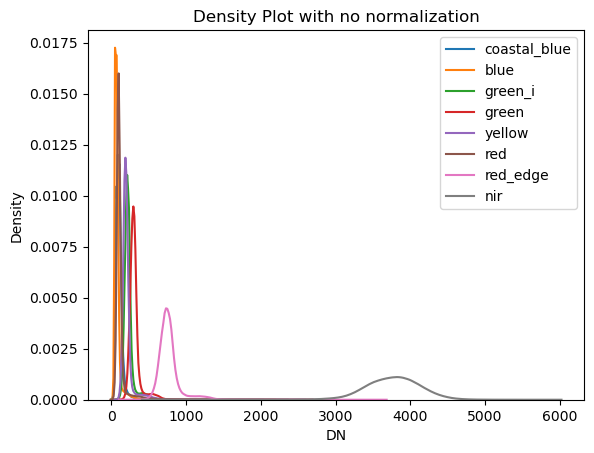

In [7]:
# look at data
for i in range(n_bands):
    sns.kdeplot(src_sr[:, :, i].flatten())

plt.title('Density Plot with no normalization')
plt.xlabel('DN')
plt.ylabel('Density')
plt.legend(band_names)


### Normalize the data


In [8]:
# # Rescaling (min-max normalization)
flat_bnds = np.zeros((src_sr[:, :, 0].size, n_bands))

for i in range(n_bands):
    bnd_i = src_sr[:, :, i].flatten()
    bnd_norm = 1024*((bnd_i - bnd_i.min())/(bnd_i.max() - bnd_i.min()))
    # print(bnd_norm.min())
    # print(bnd_norm.max())
    flat_bnds[:, i] = bnd_norm

flat_bnds.shape

(5385876, 8)

In [9]:
stats_norm = []
for i in range(n_bands):
    band = flat_bnds[:, i]

    stats_norm.append({
        'band': i + 1,
        'min': band.min(),
        'mean': band.mean(),
        'max': band.max(),
        'std': int(np.std(band)),
        'var': int(np.var(band)),
    })

smry_norm = pd.DataFrame.from_records(
    stats_norm, index='band').astype(int)

smry_norm

,min,mean,max,std,var
band,,,,,
1,0,52,1024,25,629
2,0,36,1024,24,591
3,0,97,1024,31,996
4,0,105,1024,32,1034
5,0,77,1024,32,1084
6,0,44,1024,32,1053
7,0,187,1024,41,1695
8,0,613,1024,71,5135


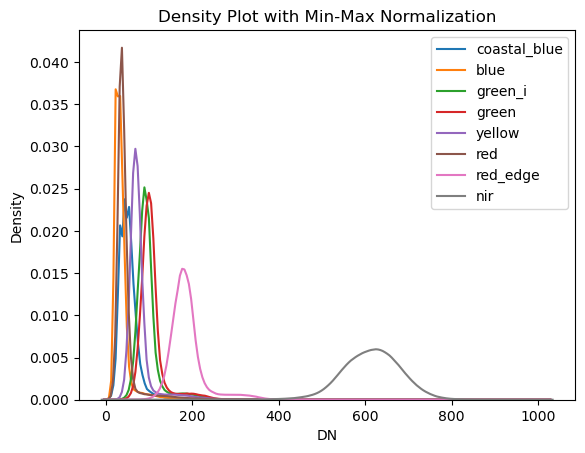

In [10]:
# look at data
for i in range(n_bands):
    sns.kdeplot(flat_bnds[:, i])

plt.title('Density Plot with Min-Max Normalization')
plt.xlabel('DN')
plt.ylabel('Density')
plt.legend(band_names)

### Covariance

To calculate the Eigen Vectors and Eigen Values we need to compute the covariance matrix. This requires the data to be cast into long format. We will reshape the 8-band data from `(9107, 12653, 8)` to `(115230871, 8)`

Then we will compute the covariance. Using the Covariance creates a non-standardized PCA. Eastman and Fulk, 1993, Carr, 1998.


In [11]:
cov_lists = np.cov(flat_bnds.transpose())
cov_data = pd.DataFrame(
    cov_lists,
    columns=band_numbers,
    index=band_numbers
)/100

cov_data = round(cov_data, 2)

cov_data

,1,2,3,4,5,6,7,8
1,6.29,4.89,5.78,5.80,6.32,6.43,6.46,-0.27
2,4.89,5.92,6.76,6.80,7.35,7.41,7.69,0.06
3,5.78,6.76,9.96,9.82,9.80,9.08,11.99,5.17
4,5.80,6.80,9.82,10.35,10.01,9.20,12.41,5.48
5,6.32,7.35,9.80,10.01,10.85,10.13,11.91,1.74
6,6.43,7.41,9.08,9.20,10.13,10.53,10.56,-1.19
7,6.46,7.69,11.99,12.41,11.91,10.56,16.95,10.63
8,-0.27,0.06,5.17,5.48,1.74,-1.19,10.63,51.36


### Correlation Matrix

To create the standardized PCA we will use the Ccorrelation matrix. (citation) suggests thestandardized PCA is better for change detection.

In [12]:
cor_lists = np.corrcoef(flat_bnds.transpose())

cor_data = pd.DataFrame(
    cor_lists,
    columns=band_numbers,
    index=band_numbers,
)

cor_data = round(cor_data, 2)
cor_data

,1,2,3,4,5,6,7,8
1,1.00,0.80,0.73,0.72,0.77,0.79,0.63,-0.02
2,0.80,1.00,0.88,0.87,0.92,0.94,0.77,0.00
3,0.73,0.88,1.00,0.97,0.94,0.89,0.92,0.23
4,0.72,0.87,0.97,1.00,0.94,0.88,0.94,0.24
5,0.77,0.92,0.94,0.94,1.00,0.95,0.88,0.07
6,0.79,0.94,0.89,0.88,0.95,1.00,0.79,-0.05
7,0.63,0.77,0.92,0.94,0.88,0.79,1.00,0.36
8,-0.02,0.00,0.23,0.24,0.07,-0.05,0.36,1.00


### Eigen Values and Vectors

In [13]:
EigVal_cov, EigVec_cov = np.linalg.eig(cov_lists)
EigVal_cor, EigVec_cor = np.linalg.eig(cor_lists)

In [14]:
unstd_eigVec_table = pd.DataFrame(
    EigVec_cov,
    columns=band_numbers,
    index=band_numbers
)

std_eigVec_table = pd.DataFrame(
    EigVec_cor,
    columns=band_numbers,
    index=band_numbers
)

unstd_eigVec_table = round(unstd_eigVec_table, 3)
std_eigVec_table = round(std_eigVec_table, 3)

In [15]:
unstd_eigVec_table

,1,2,3,4,5,6,7,8
1,0.192,0.183,-0.729,-0.626,0.000,0.079,-0.007,0.003
2,0.221,0.199,-0.268,0.336,-0.022,-0.769,0.364,-0.047
3,0.344,0.173,0.089,0.045,0.611,-0.098,-0.508,-0.447
4,0.353,0.173,0.155,-0.006,0.454,0.118,0.184,0.754
5,0.331,0.250,0.006,0.229,-0.030,0.545,0.553,-0.414
6,0.291,0.292,-0.209,0.446,-0.481,0.180,-0.519,0.232
7,0.463,0.135,0.545,-0.481,-0.432,-0.218,-0.005,-0.069
8,0.513,-0.837,-0.156,0.097,-0.031,0.030,0.001,-0.002


In [16]:
std_eigVec_table

,1,2,3,4,5,6,7,8
1,0.331,-0.212,-0.854,0.341,-0.008,0.001,0.020,-0.001
2,0.379,-0.165,-0.073,-0.630,-0.129,0.042,-0.460,-0.444
3,0.392,0.098,0.154,0.104,0.538,0.355,-0.431,0.448
4,0.391,0.113,0.192,0.182,-0.330,-0.726,-0.235,0.272
5,0.394,-0.062,0.167,-0.038,-0.610,0.508,0.331,0.269
6,0.382,-0.201,0.071,-0.345,0.448,-0.280,0.638,0.061
7,0.368,0.261,0.275,0.487,0.107,0.094,0.125,-0.669
8,0.062,0.891,-0.311,-0.293,-0.016,0.006,0.127,0.062


In [17]:
# Ordering Eigen values and vectors
# and projecting data on Eigen vector
# directions results in Principal Components

order1 = EigVal_cov.argsort()[::-1]
order2 = EigVal_cor.argsort()[::-1]

EigVal_cov = EigVal_cov[order1]
EigVal_cor = EigVal_cor[order2]

In [18]:
pc_values_cov = (EigVal_cov/sum(EigVal_cov)*100).round(2)
pc_values_cor = (EigVal_cor/sum(EigVal_cor)*100).round(2)

sum(pc_values_cov[0:3])
sum(pc_values_cor[0:3])

print(
    f'variance accounted for by first 3 components of the un-std: {sum(pc_values_cov[0:3])}%')
print(
    f'variance accounted for by first 3 components of the std: {sum(pc_values_cor[0:3])}%')

variance accounted for by first 3 components of the un-std: 97.37%
variance accounted for by first 3 components of the std: 95.95%


**Here we see 97.37% of the variance in the original dataset is accounted for in just the first three principle components!**




## What Does It Mean?

We can determine correlation between the original bands and the newly calculate
principle components by calculating a table of factor loadings<sup id='a4'>[4](#f4)</sup>

In the table below, we see that PC8 has the highest factor loadings with the NIR and Red Edge bands, so PC1 has retained most of the information in those bands.

PC8, however, has very low factor loading values and contains mostly noise.

In [19]:
loading_cov = pd.DataFrame(
    EigVec_cov * np.sqrt(EigVal_cov) / np.sqrt(np.abs(cov_lists)),
    columns=pc_names,
    index=band_names,
)

loading_cov = round(loading_cov, 3)
loading_cov

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
coastal_blue,0.632,0.571,-0.530,-0.311,0.000,0.021,-0.002,0.003
blue,0.827,0.562,-0.180,0.154,-0.006,-0.193,0.077,-0.103
green_i,1.184,0.459,0.049,0.017,0.160,-0.022,-0.085,-0.109
green,1.213,0.456,0.087,-0.002,0.117,0.027,0.030,0.178
yellow,1.089,0.636,0.003,0.086,-0.007,0.117,0.093,-0.174
red,0.949,0.739,-0.121,0.176,-0.123,0.038,-0.093,0.118
red_edge,1.509,0.334,0.275,-0.163,-0.102,-0.046,-0.001,-0.012
nir,8.136,-23.105,-0.120,0.050,-0.019,0.019,0.000,-0.000


In [20]:
loading_cor = pd.DataFrame(
    EigVec_cor * np.sqrt(EigVal_cor) / np.sqrt(np.abs(cor_lists)),
    columns=pc_names,
    index=band_names,
)

loading_cor = round(loading_cor, 3)
loading_cor

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
coastal_blue,0.820,-0.257,-0.594,0.154,-0.002,0.000,0.005,-0.002
blue,1.050,-0.178,-0.046,-0.259,-0.033,0.010,-0.096,-1.276
green_i,1.137,0.113,0.091,0.040,0.137,0.087,-0.082,0.161
green,1.145,0.131,0.116,0.070,-0.084,-0.179,-0.044,0.096
yellow,1.117,-0.070,0.102,-0.015,-0.151,0.121,0.065,0.170
red,1.067,-0.224,0.045,-0.141,0.114,-0.065,0.131,0.047
red_edge,1.154,0.322,0.170,0.193,0.028,0.025,0.023,-0.191
nir,1.255,16.126,-0.387,-0.230,-0.014,0.006,0.039,0.011


Text(0.5, 1.0, 'Information retention - unstandardized (covariance)')

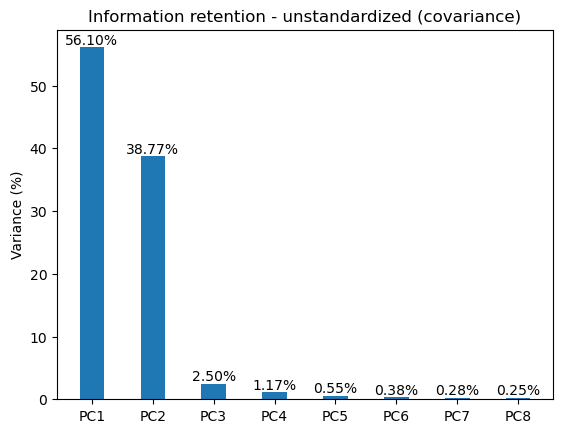

In [21]:
fig, ax = plt.subplots()

pc_bars = ax.bar(
    [1, 2, 3, 4, 5, 6, 7, 8],
    (EigVal_cov/sum(EigVal_cov)*100).round(2),
    align='center',
    width=0.4,
    tick_label=pc_names,
)

plt.bar_label(pc_bars, labels=[f'{x/100:.2%}' for x in pc_bars.datavalues])
plt.ylabel('Variance (%)')
plt.title('Information retention - unstandardized (covariance)')

Text(0.5, 1.0, 'Information retention - standardized (correlation)')

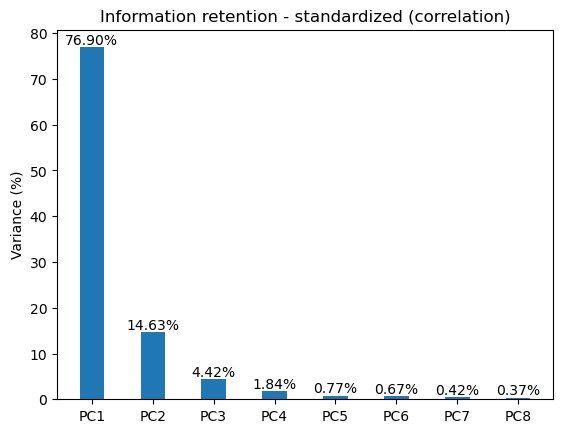

In [22]:
fig, ax = plt.subplots()

pc_bars = ax.bar(
    [1, 2, 3, 4, 5, 6, 7, 8],
    (EigVal_cor/sum(EigVal_cor)*100).round(2),
    align='center',
    width=0.4,
    tick_label=pc_names,
)

plt.bar_label(pc_bars, labels=[f'{x/100:.2%}' for x in pc_bars.datavalues])
plt.ylabel('Variance (%)')
plt.title('Information retention - standardized (correlation)')

## Create the PCA components for the Imagery

In [23]:
PC_unstd = np.matmul(flat_bnds, EigVec_cov)  # cross product
PC_std = np.matmul(flat_bnds, EigVec_cor)  # cross product

print(PC_unstd.shape)
print(PC_std.shape)

(5385876, 8)
(5385876, 8)


In [24]:
stats_unstd_PC = []
for i in range(n_bands):
    band = PC_unstd[:, i]

    stats_unstd_PC.append({
        'band': i + 1,
        'min': band.min(),
        'mean': band.mean(),
        'max': band.max(),
        'std': int(np.std(band)),
        'var': int(np.var(band)),
    })

smry_unstd_PC = pd.DataFrame.from_records(
    stats_unstd_PC, index='band').astype(int)

smry_unstd_PC

,min,mean,max,std,var
band,,,,,
1,48,529,2439,82,6855
2,-629,-404,752,68,4738
3,-749,-25,89,17,305
4,-103,-9,187,11,142
5,-159,-16,316,8,66
6,-274,7,95,6,46
7,-51,2,139,5,33
8,-77,0,59,5,30


In [25]:
stats_std_PC = []
for i in range(n_bands):
    band = PC_std[:, i]

    stats_std_PC.append({
        'band': i + 1,
        'min': band.min(),
        'mean': band.mean(),
        'max': band.max(),
        'std': int(np.std(band)),
        'var': int(np.var(band)),
    })

smry_std_PC = pd.DataFrame.from_records(
    stats_std_PC, index='band').astype(int)

smry_std_PC

,min,mean,max,std,var
band,,,,,
1,25,265,2541,78,6206
2,-4,586,1001,69,4890
3,-548,-135,136,23,552
4,-270,-82,80,17,311
5,-93,-4,72,6,36
6,-48,7,79,5,31
7,-92,73,269,10,116
8,-74,-7,168,8,76


## Reshape to image stack

In [26]:

PC_unstd_2d = np.zeros((img_shape[0], img_shape[1], n_bands))
for i in range(n_bands):
    PC_unstd_2d[:, :, i] = PC_unstd[:, i].reshape(-1, img_shape[1])

PC_std_2d = np.zeros((img_shape[0], img_shape[1], n_bands))
for i in range(n_bands):
    PC_std_2d[:, :, i] = PC_std[:, i].reshape(-1, img_shape[1])

print(PC_unstd_2d.shape)
print(PC_std_2d.shape)

(1874, 2874, 8)
(1874, 2874, 8)


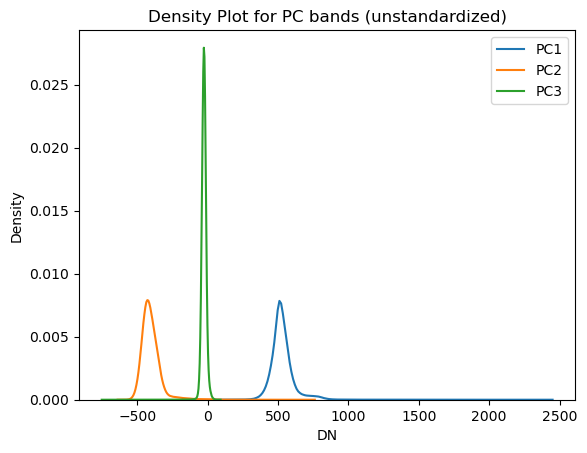

In [27]:
# look at PC data
for i in range(3):
    sns.kdeplot(PC_unstd_2d[:, :, i].flatten())

plt.title('Density Plot for PC bands (unstandardized)')
plt.xlabel('DN')
plt.ylabel('Density')
plt.legend(pc_names[0:3])

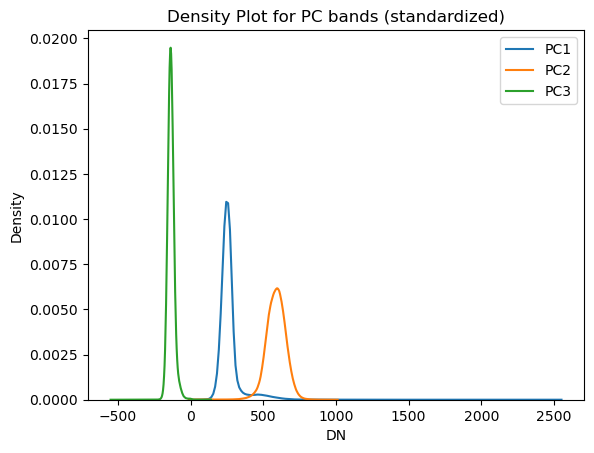

In [28]:
# look at PC data
for i in range(3):
    sns.kdeplot(PC_std_2d[:, :, i].flatten())

plt.title('Density Plot for PC bands (standardized)')
plt.xlabel('DN')
plt.ylabel('Density')
plt.legend(pc_names[0:3])

In [29]:
# Rescaling (min-max normalization)
PC_nrm = np.zeros(PC_std.shape)

for i in range(n_bands):
    PC_i = PC_std[:, i]
    pc_norm_mm = 1024*(PC_i - PC_i.min())/(PC_i.max() - PC_i.min())
    PC_nrm[:, i] = pc_norm_mm

print(PC_nrm.shape)

PC_std_2d_norm = np.zeros((img_shape[0], img_shape[1], n_bands))
for i in range(n_bands):
    PC_std_2d_norm[:, :, i] = PC_nrm[:, i].reshape(-1, img_shape[1])

print(PC_std_2d_norm.shape)

(5385876, 8)
(1874, 2874, 8)


In [30]:
# # look at normalized PC data
# for i in range(n_bands):
#     sns.kdeplot(PC_2d_norm[:, :, i].flatten())

# plt.title('Density Plot for Normalized PC bands')
# plt.xlabel('DN')
# plt.ylabel('Density')
# plt.legend(pc_names)

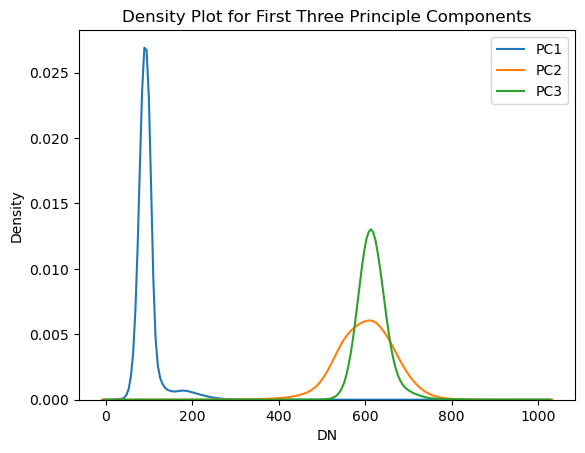

In [31]:
# look at normalized PC data
for i in range(3):
    sns.kdeplot(PC_std_2d_norm[:, :, i].flatten())

plt.title('Density Plot for First Three Principle Components')
plt.xlabel('DN')
plt.ylabel('Density')
plt.legend(pc_names[0:3])

In [32]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count=8)

In [33]:
# band, row, col
tmp_unstd = np.moveaxis(PC_unstd_2d, [0, 1, 2], [2, 1, 0])
PC_img_unstd = np.swapaxes(tmp_unstd, 1, 2)

tmp_std = np.moveaxis(PC_std_2d, [0, 1, 2], [2, 1, 0])
PC_img_std = np.swapaxes(tmp_std, 1, 2)

tmp_std_norm = np.moveaxis(PC_std_2d_norm, [0, 1, 2], [2, 1, 0])
PC_img_std_norm = np.swapaxes(tmp_std_norm, 1, 2)

print(PC_img_unstd.shape)
print(PC_img_std.shape)
print(PC_img_std_norm.shape)

(8, 1874, 2874)
(8, 1874, 2874)
(8, 1874, 2874)


In [34]:
# Write band calculations to a new raster file
with rasterio.open('./data/analytic/0_derived/PC_img_unstd.tif', 'w', **kwargs) as dst:
    dst.write(PC_img_unstd.astype(rasterio.float32))

# Write band calculations to a new raster file
with rasterio.open('./data/analytic/0_derived/PC_img_std.tif', 'w', **kwargs) as dst:
    dst.write(PC_img_std.astype(rasterio.float32))


# Write band calculations to a new raster file
with rasterio.open('./data/analytic/0_derived/PC_img_std_norm.tif', 'w', **kwargs) as dst:
    dst.write(PC_img_std_norm.astype(rasterio.float32))

In [35]:
end = datetime.now()
diff = end-start
diff.total_seconds()


348.080895